В рамках подготовки данных для кластеризации к датасету добавлен новый атрибут — удельная мощность автомобиля (power_to_weight), рассчитываемая как отношение мощности двигателя (horsepower) к массе автомобиля (weight).
Этот показатель отражает динамические характеристики автомобиля: чем выше значение, тем выше ускорение и спортивность модели.
Новый атрибут позволит более чётко дифференцировать автомобили по классам производительности при дальнейшем применении алгоритма K-Means.

In [36]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

df = pd.read_csv("Automobile.csv")

# Удельная мощность - новый атрибут
df['power_to_weight'] = df['horsepower'] / df['weight']

# Проверка на корректность
print(df[['horsepower', 'weight', 'power_to_weight']].head())

   horsepower  weight  power_to_weight
0       130.0    3504         0.037100
1       165.0    3693         0.044679
2       150.0    3436         0.043655
3       150.0    3433         0.043694
4       140.0    3449         0.040591


Проверим наличие пропущенных значений: 

In [37]:
print(df.isna().sum())

name               0
mpg                0
cylinders          0
displacement       0
horsepower         6
weight             0
acceleration       0
model_year         0
origin             0
power_to_weight    6
dtype: int64


Видно 6 пропущенных значений в horsepower и в power_to_weight. Для сохранения полноты данных и предотвращения потери записей пропуски были заменим средним арифметическим значением по данным признакам.
Такой подход позволяет сохранить распределение данных без смещения и обеспечивает корректную работу последующих алгоритмов анализа.

In [38]:
mean_hp = df['horsepower'].mean()
df['horsepower'] = df['horsepower'].fillna(mean_hp)

# пересчёт power_to_weight после заполнения horsepower
df['power_to_weight'] = df['horsepower'] / df['weight']

print(df.isna().sum())

name               0
mpg                0
cylinders          0
displacement       0
horsepower         0
weight             0
acceleration       0
model_year         0
origin             0
power_to_weight    0
dtype: int64


Показатель power_to_weight был пересчитан, чтобы новые значения мощности отразились корректно.

Найдем и обработаем дубли, если таковые имеются. 

In [40]:
duplicates = df.duplicated().sum()
print(duplicates)

0


Проверка на наличие дублирующихся записей показала, что таких строк в датасете нет.

Обработаем выбросы. Сначала увидим их.

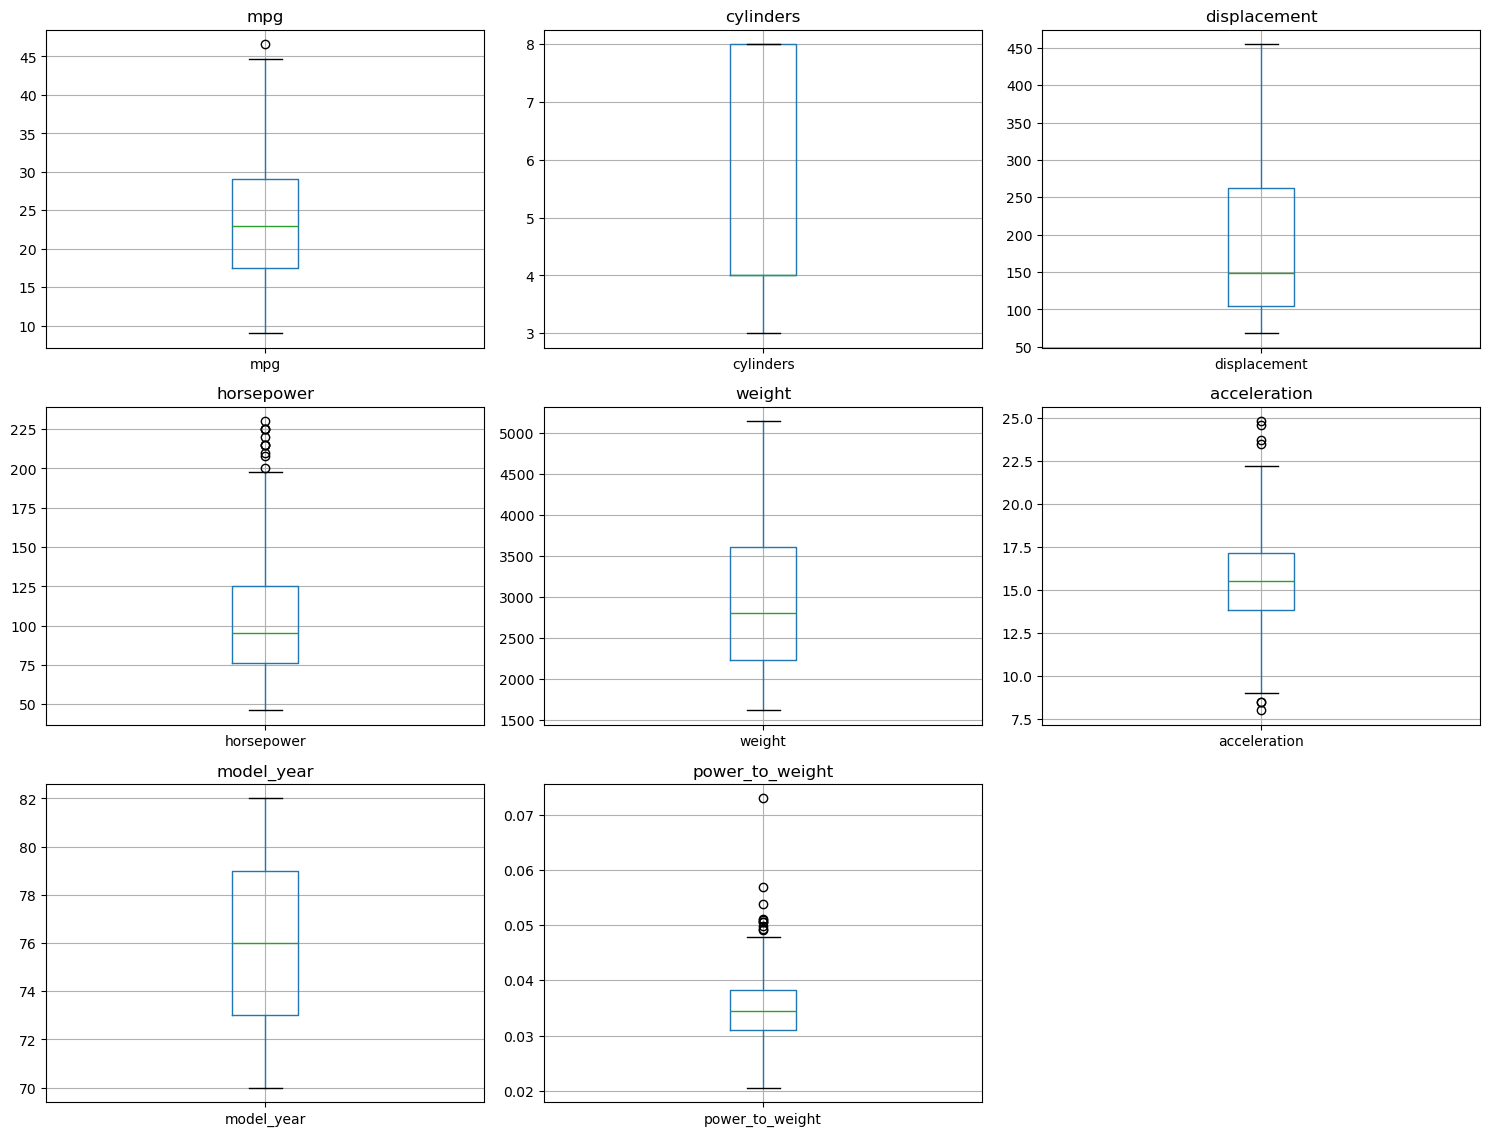

In [41]:
import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include='number').columns

# Сетка графиков 4x3 и отдельный boxplot для каждого признака
plt.figure(figsize=(15, 15))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    df.boxplot(column=col)
    plt.title(col)
    plt.tight_layout()
plt.show()

Для устранения выбросов, потенциально искажающих распределения данных и результаты кластеризации, применим метод межквартильного размаха (IQR) с классическим коэффициентом 1.5. Метод позволяет статистически определить диапазон нормальных значений для каждого числового признака и исключить точки, находящиеся за его пределами.

In [42]:
# Функция для удаления выбросов методом межквартильного размаха
def remove_outliers_iqr(data, cols):
    cleaned = data.copy()
    for col in cols:
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned = cleaned[(cleaned[col] >= lower) & (cleaned[col] <= upper)]
    return cleaned

# Удаление выбросов для всех числовых признаков
df_clean = remove_outliers_iqr(df, numeric_cols)

print(f"Размер датасета до очистки: {df.shape[0]} строк")
print(f"Размер датасета после удаления выбросов: {df_clean.shape[0]} строк")

Размер датасета до очистки: 398 строк
Размер датасета после удаления выбросов: 370 строк


После фильтрации объём выборки сократился с 398 до 370 строк, что составляет менее 8% от исходного числа записей - в пределах нормы.
Boxplot-графики:

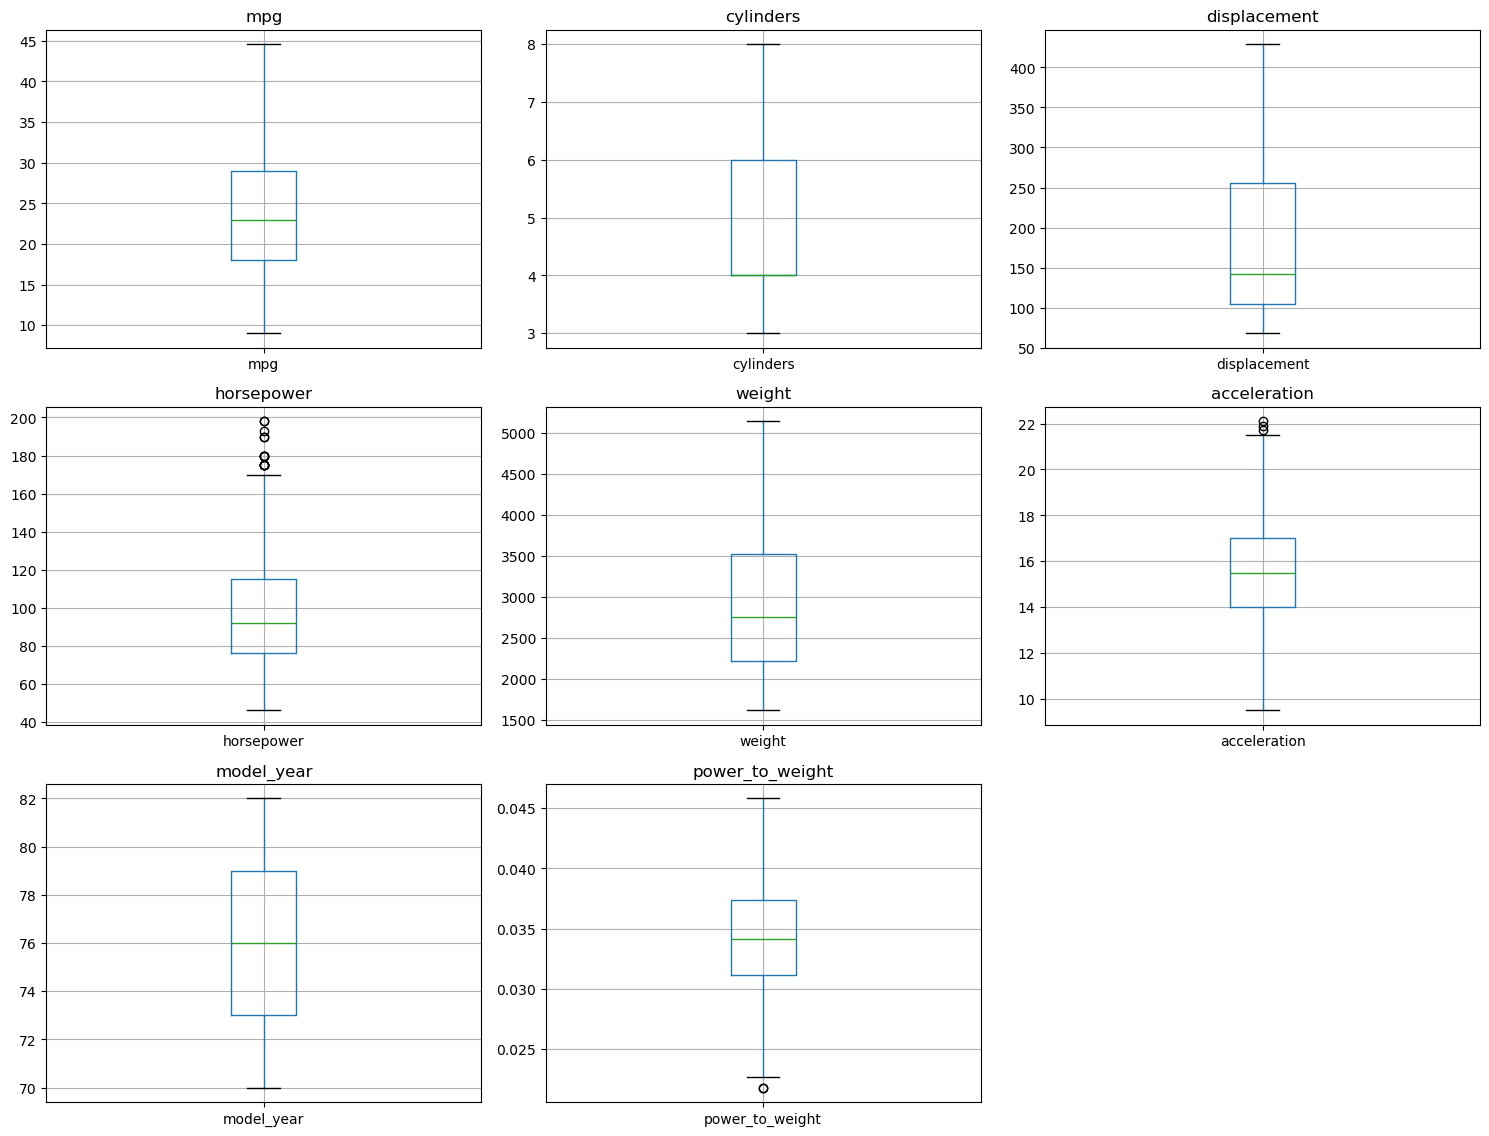

In [43]:
plt.figure(figsize=(15, 15))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    df_clean.boxplot(column=col)
    plt.title(col)
    plt.tight_layout()
plt.show()

На графиках видно, что распределения стали более компактными, однако в признаках horsepwer, acceleration, power_to_weight остаются несколько точек, выходящих за пределы усов. Значения соответсвуют автомобилям с высокой мощностью и не являются ошибками измерений (1 выброс в power_to_weight - тяжелый и медленнный автомобиль), поэтому решено оставить их в данных, чтобы сохранить их репрезентативность и полноту.

Проверим датасет на наличие "кривых" данных. Под такими данными понимаются физически невозможные значения - отрицательные или нулевые величины мощности, массы или расхода топлива. Проверим, присутствуют ли такие случаи после очистки.

In [44]:
invalid_rows = df_clean[
    (df_clean['horsepower'] <= 0) |
    (df_clean['weight'] <= 0) |
    (df_clean['mpg'] <= 0)
]
print(len(invalid_rows))

0


Все автомобили имеют корректные показатели мощности, веса и расхода топлива. 

Проведем визуальный анализ данных, чтобы выявить возможные закономерности между основными параметрами автомобилей. Для этого построим диаграммы рассеивания между ключевыми числовыми признаками - horsepower, weight, acceleration, mpg, power_to_weight. Такие графики позволяют наглядно определить естественные группы (потенциальные кластеры) внутри набора данных.

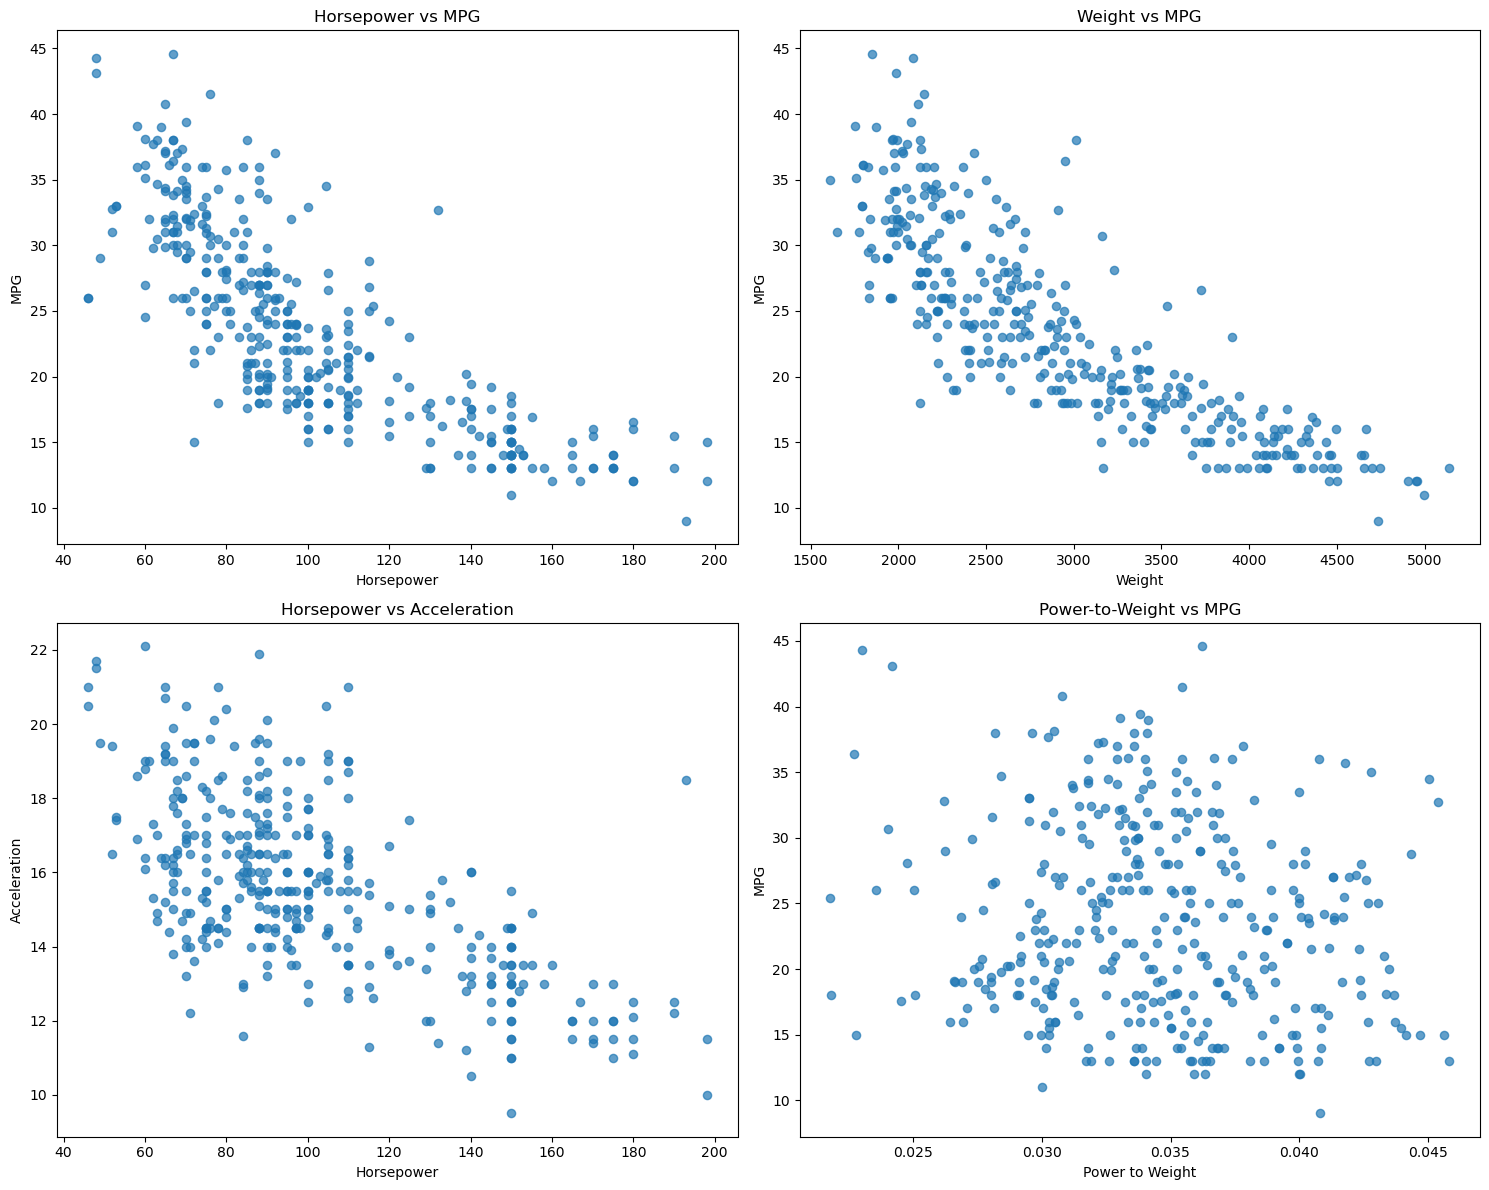

In [45]:
plt.figure(figsize=(15, 12))

# horsepower vs mpg
plt.subplot(2, 2, 1)
plt.scatter(df_clean['horsepower'], df_clean['mpg'], s=35, alpha=0.7)
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Horsepower vs MPG')

# weight vs mpg
plt.subplot(2, 2, 2)
plt.scatter(df_clean['weight'], df_clean['mpg'], s=35, alpha=0.7)
plt.xlabel('Weight')
plt.ylabel('MPG')
plt.title('Weight vs MPG')

# horsepower vs acceleration
plt.subplot(2, 2, 3)
plt.scatter(df_clean['horsepower'], df_clean['acceleration'], s=35, alpha=0.7)
plt.xlabel('Horsepower')
plt.ylabel('Acceleration')
plt.title('Horsepower vs Acceleration')

# power_to_weight vs mpg
plt.subplot(2, 2, 4)
plt.scatter(df_clean['power_to_weight'], df_clean['mpg'], s=35, alpha=0.7)
plt.xlabel('Power to Weight')
plt.ylabel('MPG')
plt.title('Power-to-Weight vs MPG')

plt.tight_layout()
plt.show()

Диаграммы показывают логичные взаимосвязи. 
На графиках horsepower-mpg и weight-mpg наблюдается четкая отрицательная зависимость: более мощные и тяжелые автомобили расходуют больше топлива. 

Между horespower и acceleration видна умеренная отрицательная корреляция - мощные автомобили, как правило, разгоняются быстрее.

График power_to_weight - mpg не демострирует строгой линейной зависимости, что объясняется нелинейной природой показателя: он зависит одновременно от массы и мощности, влияющих на экономичность в разных направлениях. Несмотря на это, данный признак остается полезным для кластеризации, так как позволяет выделить автомобили с различными уровнями производительности.

В целом визуальный анализ позволяет преположить наличие нескольких естественных групп: экономичные и маломощные автомобили, среднеразмерные модели с умеренными характеристиками и мощные тяжелые машины с высоким расходом топлива. 

Проведем кластеризацию автомобилей с использованием алгоритма K-Means, входящего в библиотеку scikit-learn.
Сначала нормализуем данные, чтобы признаки имели сопоставимые масштабы. Для устойчивости к возможным выбросам применим RobustScaler, который масштабирует данные на основе медианы и межквартильного размаха (IQR).

In [46]:
from sklearn.preprocessing import RobustScaler

# Признаки для кластеризации
features = ['horsepower', 'weight', 'acceleration', 'mpg', 'power_to_weight']
X = df_clean[features]

# Масштабирование данных
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print("Размерность матрицы признаков:", X_scaled.shape)
print("Пример масштабированных данных:")
print(X_scaled[:5])

Размерность матрицы признаков: (370, 5)
Пример масштабированных данных:
[[ 0.97435897  0.57833174 -1.16666667 -0.45454545  0.47863216]
 [ 1.87179487  0.72329818 -1.33333333 -0.72727273  1.7047874 ]
 [ 1.48717949  0.5261745  -1.5        -0.45454545  1.53916107]
 [ 1.48717949  0.52387344 -1.16666667 -0.63636364  1.54533325]
 [ 1.23076923  0.53614573 -1.66666667 -0.54545455  1.04344547]]


Для выбора подходящего числа кластеров k применим 2 метода:
Метод локтя: оценивает, при каком значении k уменьшение внутрикластерной инерции (суммы квадроатов расстояний до центров кластеров) перестает быть значительным.
Метод силуэта: измеряет, насколько хорошо каждый объект принадлежит своему кластеру по сравнению с соседними.
Наилучшее значение k соответствует пику коэффициента силуэта.

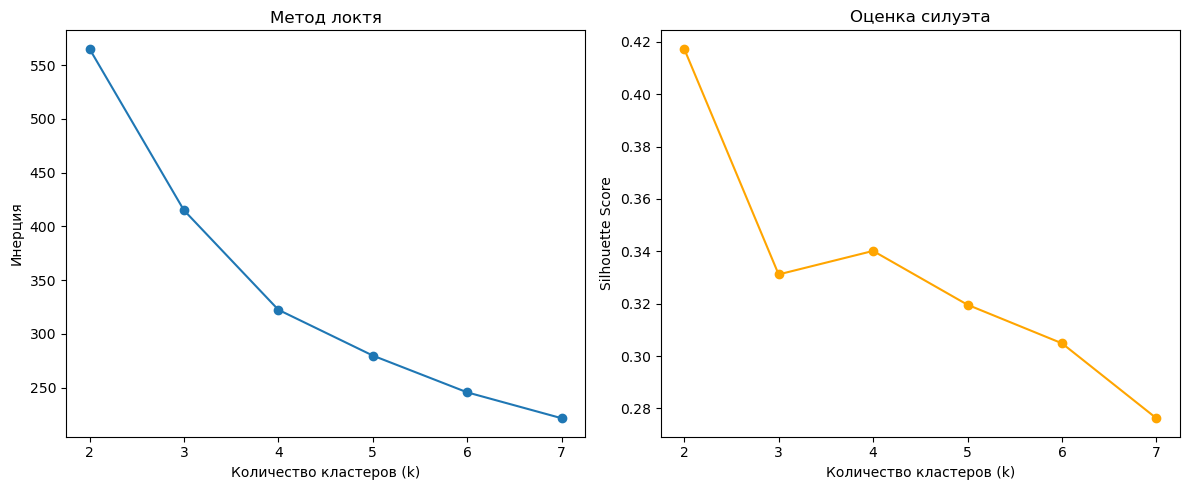

Оптимальное количество кластеров (по методу силуэта): 2


In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
silhouette = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

# График метода локтя
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')

# График силуэта
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette, marker='o', color='orange')
plt.title('Оценка силуэта')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Определим лучшее k
best_k = k_range[silhouette.index(max(silhouette))]
print("Оптимальное количество кластеров (по методу силуэта):", best_k)

В результате анализа по методу локтя и методу силуэта оптимальным числом кластеров было выбрано k = 2. Это значение обеспечивает наилучший баланс между компактностью групп и их разделимостью. Дальнейшее увеличение числа кластеров приводит к переусложнению модели и ухудшению метрики силуэта. Однако стоит отметить, что по графику метода локтя точка перегиба наблюдается в диапазоне k = 2–3.
Это может указывать на существование промежуточной группы автомобилей — моделей со сбалансированными характеристиками, которые не относятся ни к явно экономичным, ни к высокопроизводительным.
Таким образом, вариант с k = 3 также имеет смысл с точки зрения содержательной интерпретации, хотя по метрике силуэта он явно уступает решению с двумя кластерами.

После выбора оптимального числа кластеров k = 2, выполним обучение модели K-Means на подготовленных данных и визуализируем результат кластеризации.

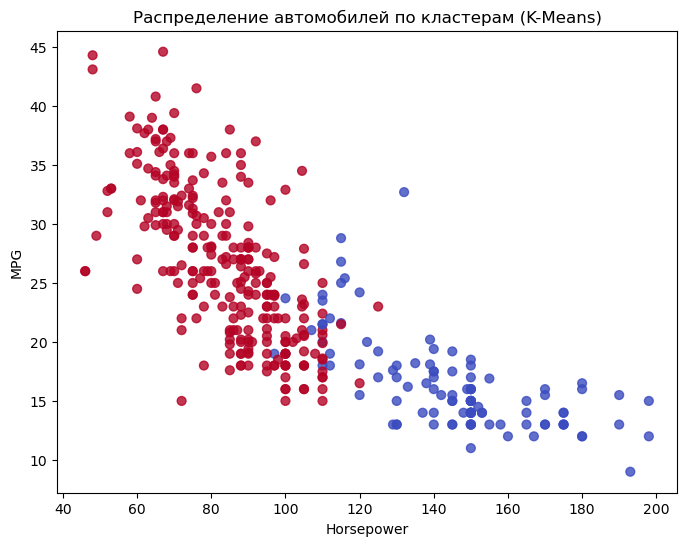

In [48]:
# Обучение KMeans с выбранным числом кластеров
k = best_k
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Добавляем метку кластера в датафрейм
df_clean['cluster'] = labels

# Визуализация кластеров по ключевым признакам
plt.figure(figsize=(8, 6))
plt.scatter(df_clean['horsepower'], df_clean['mpg'], c=df_clean['cluster'], cmap='coolwarm', s=40, alpha=0.8)
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.title('Распределение автомобилей по кластерам (K-Means)')
plt.show()

Вывод: В ходе работы применен метод кластеризации K-Means к данным о технических характеристиках автомобилей. Оптимальное кол-во кластеров k = 2 по методу силуэта. 
Визуализация показала, что выборка логично разделяется на две группы:
Кластер 0 (синие точки) - автомобили с высокой мощностью, большим весом и низкой топливной экономичностью (низкий mpg). Как правило, это тяжелые и мощные авто.
Кластер 1 (красные точки) - автомобили с низкой мощностью, меньшей массой и высоким mpg, то есть более экономичные и легкие модели. 
Результаты подтверждают применимость выбранного набора признаков и подготовленных данных для задач кластеризации. 